SYSTEM INFORMATION
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA: True
Device: Tesla T4
CUDA Version: 12.6
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Transformers: 4.57.1
✓ Datasets: 4.2.0
Upload kaggle.json:


Saving kaggle.json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset
License(s): CC0-1.0
  0% 0.00/62.5M [00:00<?, ?B/s]
100% 62.5M/62.5M [00:00<00:00, 1.71GB/s]
✓ Found: /content/Resume/Resume.csv
✓ Loaded: 2,484 resumes
✓ Cleaned: 2,483 resumes


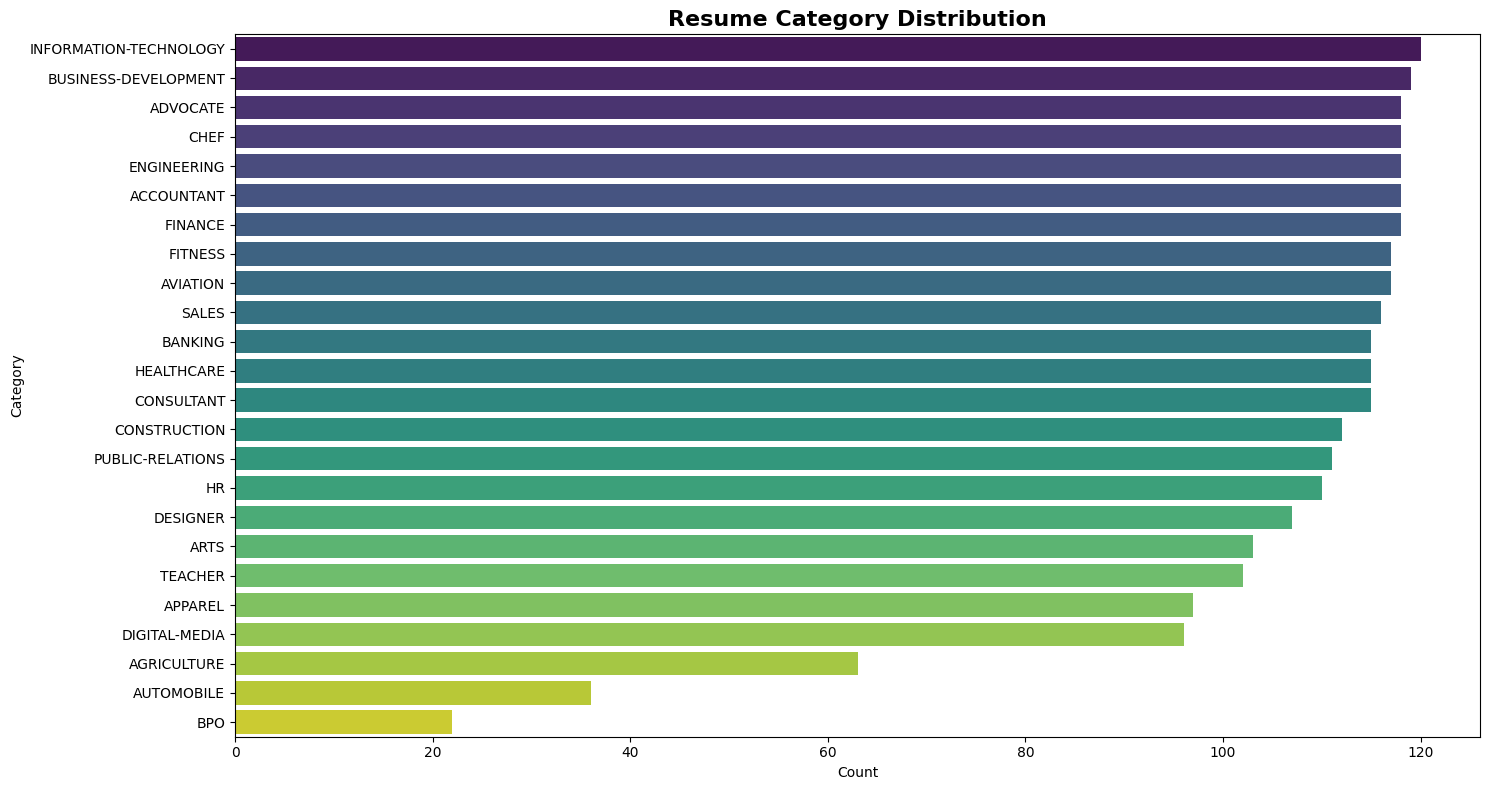

Train: 1986 | Val: 248 | Test: 249


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cuda
LR: 3e-05 | Epochs: 6 | Batch: 16 | Accum: 2

Epoch 1/6


Evaluating: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


Train Loss: 3.0810 | Train Acc: 0.1108
Val Loss: 2.6747 | Val Acc: 0.3548 | Val F1: 0.3078
Time: 1.34 min
✓ Best model saved (F1: 0.3078)

Epoch 2/6


Evaluating: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Train Loss: 2.0368 | Train Acc: 0.5891
Val Loss: 1.3635 | Val Acc: 0.7500 | Val F1: 0.7145
Time: 1.09 min
✓ Best model saved (F1: 0.7145)

Epoch 3/6


Evaluating: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Train Loss: 1.1292 | Train Acc: 0.8122
Val Loss: 0.9647 | Val Acc: 0.8024 | Val F1: 0.7826
Time: 1.16 min
✓ Best model saved (F1: 0.7826)

Epoch 4/6


Evaluating: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


Train Loss: 0.7709 | Train Acc: 0.8716
Val Loss: 0.8161 | Val Acc: 0.8266 | Val F1: 0.8160
Time: 1.05 min
✓ Best model saved (F1: 0.8160)

Epoch 5/6


Evaluating: 100%|██████████| 16/16 [00:08<00:00,  1.95it/s]


Train Loss: 0.6132 | Train Acc: 0.9023
Val Loss: 0.7593 | Val Acc: 0.8508 | Val F1: 0.8402
Time: 1.08 min
✓ Best model saved (F1: 0.8402)

Epoch 6/6


Evaluating: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


Train Loss: 0.5586 | Train Acc: 0.9144
Val Loss: 0.7418 | Val Acc: 0.8508 | Val F1: 0.8402
Time: 1.08 min


Evaluating: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]



TEST RESULTS
Accuracy: 0.8835 (88.35%)
F1-Score: 0.8756 (87.56%)
Precision: 0.8763 | Recall: 0.8835


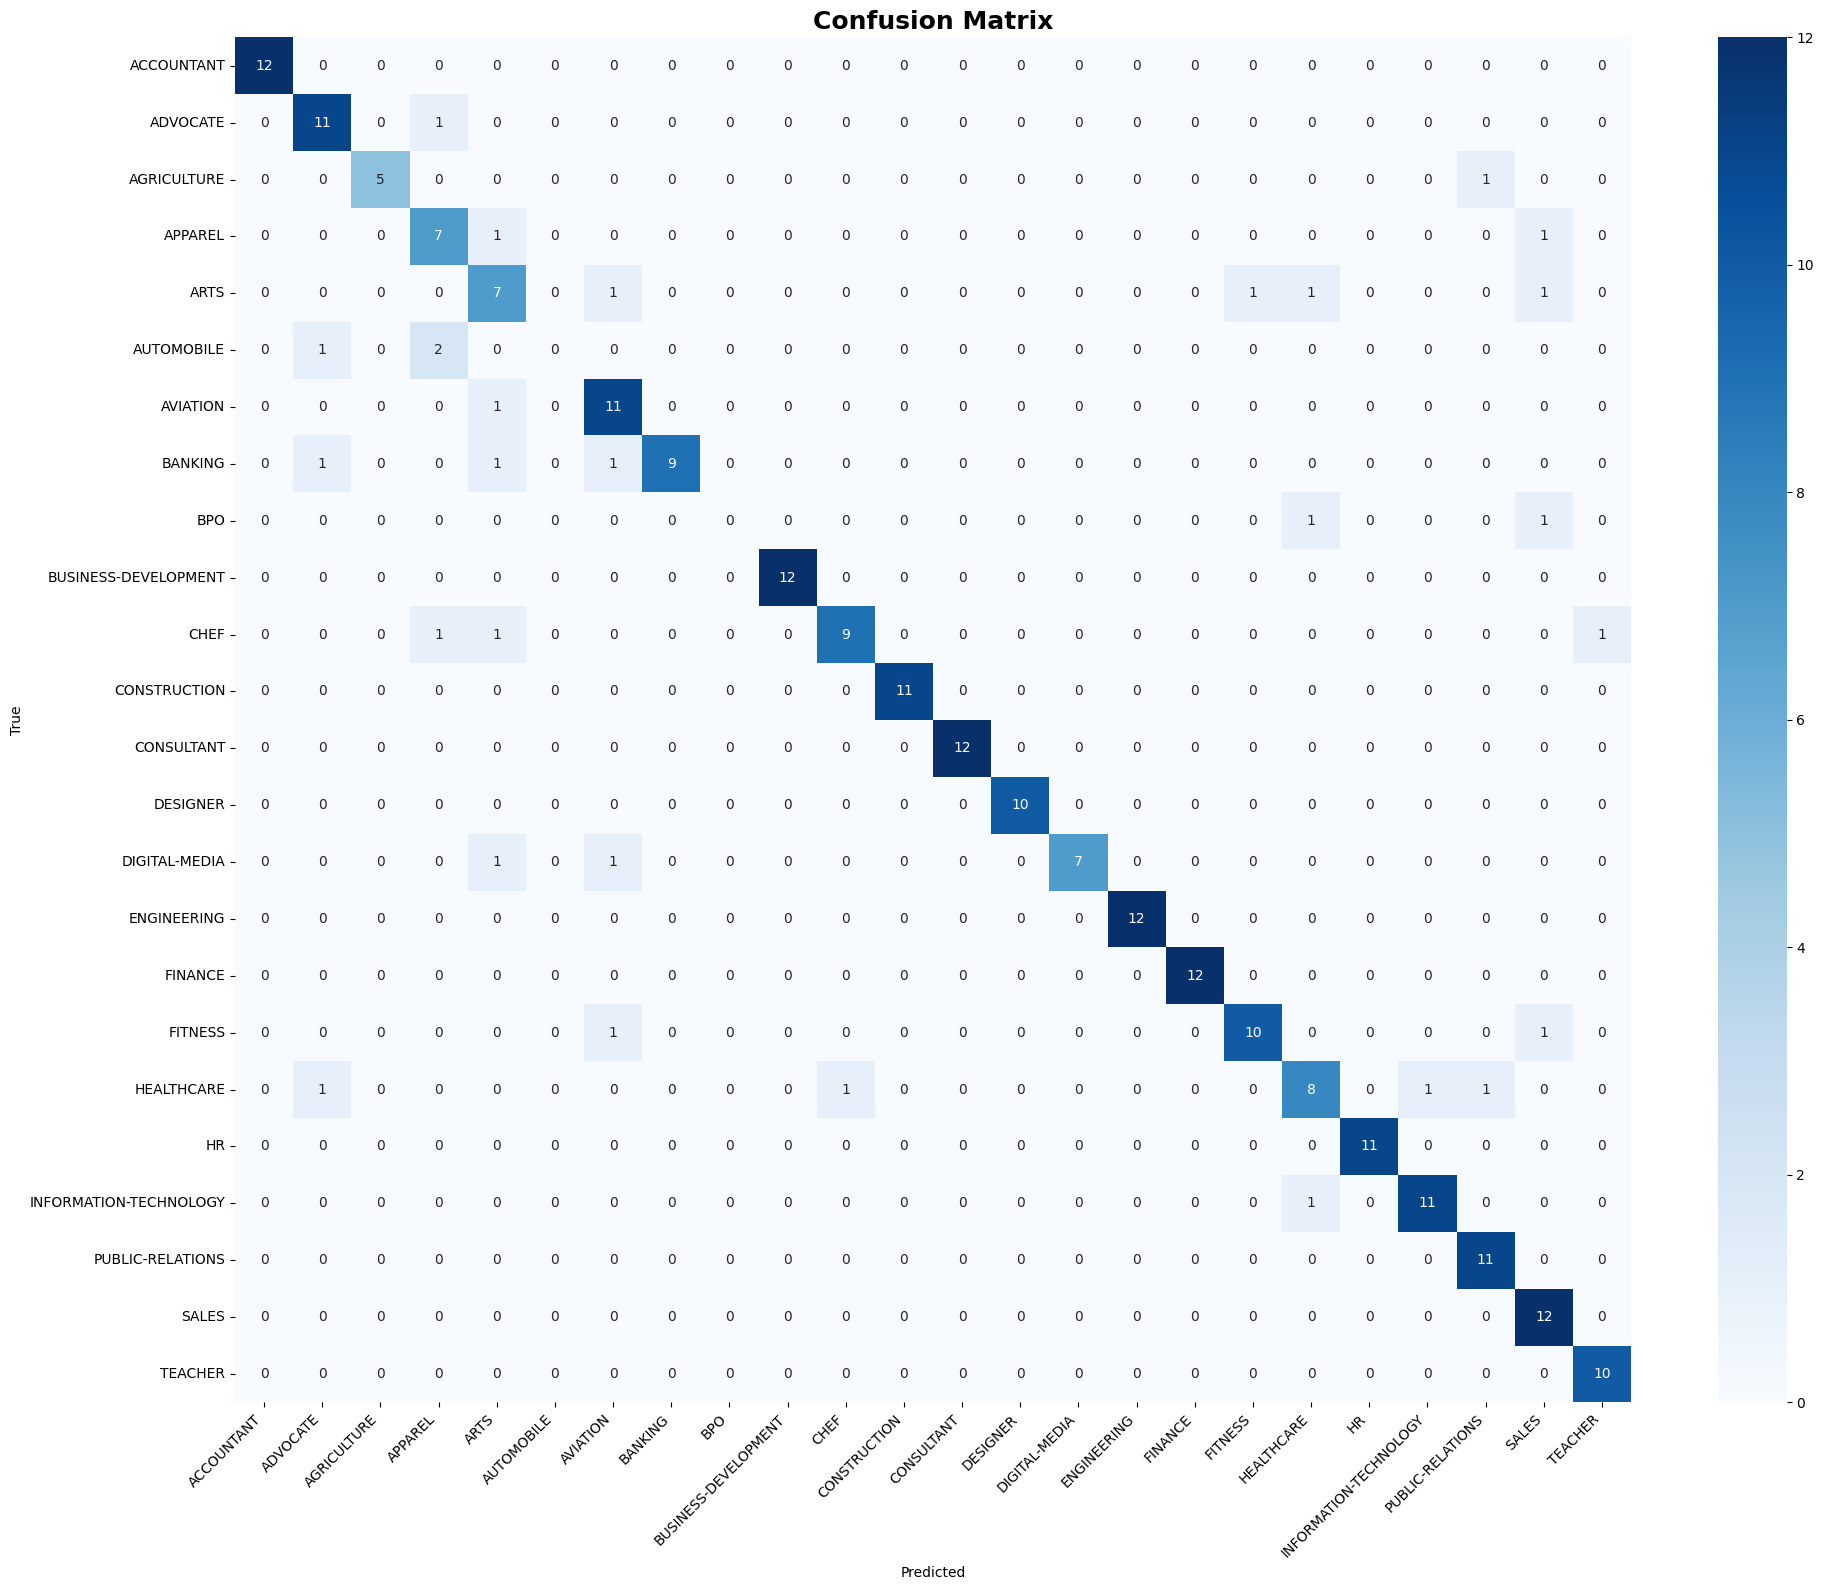


✓ ALL FILES SAVED TO GOOGLE DRIVE
Final Test Accuracy: 88.35% | F1: 87.56%


In [4]:
# ═══════════════════════════════════════════════════════════════════
# OPTIMIZED RESUME CLASSIFICATION SYSTEM - VERIDIA.IO
# ═══════════════════════════════════════════════════════════════════

import torch
import sys
print("="*70)
print("SYSTEM INFORMATION")
print("="*70)
print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
print("="*70)

from google.colab import drive
drive.mount('/content/drive')

# Install packages
!pip install -q --upgrade huggingface-hub transformers datasets accelerate sentencepiece
!pip install -q pdfplumber python-docx seaborn wordcloud

import transformers, datasets, pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns, warnings, re, os, shutil, pickle, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from transformers import BertTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
warnings.filterwarnings('ignore')

print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ Datasets: {datasets.__version__}")

# ═══════════════════════════════════════════════════════════════════
# KAGGLE SETUP & DATA DOWNLOAD (FIXED)
# ═══════════════════════════════════════════════════════════════════
!pip install -q kaggle
from google.colab import files
print("Upload kaggle.json:")
uploaded = files.upload()
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# Clean up old files
!rm -rf /content/data /content/Resume /content/resume-dataset.zip

# Download and extract
!kaggle datasets download -d snehaanbhawal/resume-dataset
!unzip -o -q resume-dataset.zip  # -o flag overwrites without asking

# Find Resume.csv
for path in ['/content/Resume/Resume.csv', '/content/data/Resume.csv']:
    if os.path.exists(path):
        shutil.copy(path, '/content/Resume.csv')
        print(f"✓ Found: {path}")
        break

df = pd.read_csv('/content/Resume.csv')
print(f"✓ Loaded: {len(df):,} resumes")


# ═══════════════════════════════════════════════════════════════════
# DATA PREPROCESSING
# ═══════════════════════════════════════════════════════════════════
def clean_resume_text(text):
    text = str(text) if text else ""
    text = re.sub(r'http\S+|www\.\S+|\S+@\S+|<.*?>|#\S+|@\S+|\bRT\b|\bcc\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip().lower()

df['cleaned_resume'] = df['Resume_str'].apply(clean_resume_text)
df = df[df['cleaned_resume'].str.len() >= 50].reset_index(drop=True)
print(f"✓ Cleaned: {len(df):,} resumes")

# Visualize
plt.figure(figsize=(15, 8))
sns.barplot(x=df['Category'].value_counts().values, y=df['Category'].value_counts().index, palette='viridis')
plt.title('Resume Category Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Count'); plt.ylabel('Category'); plt.tight_layout()
plt.savefig('category_distribution.png', dpi=300); plt.show()

# ═══════════════════════════════════════════════════════════════════
# LABEL ENCODING & SPLIT
# ═══════════════════════════════════════════════════════════════════
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Category'])
num_categories = len(label_encoder.classes_)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# ═══════════════════════════════════════════════════════════════════
# DATASET & DATALOADER
# ═══════════════════════════════════════════════════════════════════
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class ResumeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts; self.labels = labels
        self.tokenizer = tokenizer; self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(str(self.texts[idx]), add_special_tokens=True,
                                   max_length=self.max_length, padding='max_length',
                                   truncation=True, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

BATCH_SIZE = 16  # Increased with gradient accumulation
train_dataset = ResumeDataset(train_df['cleaned_resume'].values, train_df['label'].values, tokenizer)
val_dataset = ResumeDataset(val_df['cleaned_resume'].values, val_df['label'].values, tokenizer)
test_dataset = ResumeDataset(test_df['cleaned_resume'].values, test_df['label'].values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

# ═══════════════════════════════════════════════════════════════════
# MODEL SETUP
# ═══════════════════════════════════════════════════════════════════
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_categories, problem_type="single_label_classification")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"✓ Model loaded on {device}")

# ═══════════════════════════════════════════════════════════════════
# OPTIMIZED TRAINING CONFIG
# ═══════════════════════════════════════════════════════════════════
LEARNING_RATE = 3e-5  # Slightly higher for better convergence
EPOCHS = 6  # More epochs with early stopping
WARMUP_RATIO = 0.1
ACCUM_STEPS = 2  # Gradient accumulation
MAX_GRAD_NORM = 1.0

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_loader) * EPOCHS // ACCUM_STEPS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_scheduler("cosine", optimizer=optimizer,
                          num_warmup_steps=warmup_steps, num_training_steps=total_steps)
scaler = GradScaler()

print(f"LR: {LEARNING_RATE} | Epochs: {EPOCHS} | Batch: {BATCH_SIZE} | Accum: {ACCUM_STEPS}")

# ═══════════════════════════════════════════════════════════════════
# TRAINING LOOP WITH MIXED PRECISION & EARLY STOPPING
# ═══════════════════════════════════════════════════════════════════
def train_epoch(model, dataloader, optimizer, scheduler, scaler, device):
    model.train(); total_loss = 0; preds, labels = [], []
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(dataloader, desc="Training")):
        with autocast():
            outputs = model(batch['input_ids'].to(device),
                          batch['attention_mask'].to(device),
                          labels=batch['labels'].to(device))
            loss = outputs.loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (i + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
            scheduler.step()

        total_loss += loss.item() * ACCUM_STEPS
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        labels.extend(batch['labels'].cpu().numpy())

    return total_loss / len(dataloader), accuracy_score(labels, preds)

def evaluate(model, dataloader, device):
    model.eval(); total_loss = 0; preds, labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            outputs = model(batch['input_ids'].to(device),
                          batch['attention_mask'].to(device),
                          labels=batch['labels'].to(device))
            total_loss += outputs.loss.item()
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())
    return total_loss / len(dataloader), accuracy_score(labels, preds), preds, labels

# Training with early stopping
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
best_f1 = 0; patience, wait = 3, 0
best_model_path = '/content/drive/MyDrive/resume_classifier_best'
os.makedirs(best_model_path, exist_ok=True)

for epoch in range(EPOCHS):
    print(f"\n{'='*70}\nEpoch {epoch + 1}/{EPOCHS}\n{'='*70}")
    start = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, scaler, device)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, device)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
    print(f"Time: {(time.time()-start)/60:.2f} min")

    if val_f1 > best_f1:
        best_f1 = val_f1; wait = 0
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"✓ Best model saved (F1: {best_f1:.4f})")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered"); break

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

# ═══════════════════════════════════════════════════════════════════
# EVALUATION
# ═══════════════════════════════════════════════════════════════════
best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path).to(device)
test_loss, test_acc, test_preds, test_labels = evaluate(best_model, test_loader, device)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"\n{'='*70}\nTEST RESULTS\n{'='*70}")
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"F1-Score: {f1:.4f} ({f1*100:.2f}%)")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.savefig('confusion_matrix.png', dpi=300); plt.show()

# Save results
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("\n✓ ALL FILES SAVED TO GOOGLE DRIVE")
print(f"Final Test Accuracy: {test_acc:.2%} | F1: {f1:.2%}")



In [5]:
# Manual ngrok installation (bypasses pyngrok timeout)
!wget -q https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xzf ngrok-v3-stable-linux-amd64.tgz
!mv ngrok /usr/local/bin/
!chmod +x /usr/local/bin/ngrok

# Configure with your token
!ngrok config add-authtoken 34ChI38GfjXEnrqpxrtBBYbL4fD_6hiub17rB3k3KGahaALCH

# Start Streamlit
!pip install -q streamlit
!pkill -f streamlit
import subprocess
subprocess.Popen(["streamlit", "run", "/content/app.py", "--server.port", "8501"])

import time
time.sleep(10)

# Start ngrok
subprocess.Popen(["ngrok", "http", "8501", "--log=stdout"])
time.sleep(5)

# Get URL
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print('Your ngrok URL:', json.load(sys.stdin)['tunnels'][0]['public_url'])"


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Your ngrok URL: https://agrarianly-charrier-maisie.ngrok-free.dev
